In [7]:
# possibly required libraries
import numpy as np
import matplotlib.pyplot as plt
import time as time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torchvision.transforms import ToTensor,Lambda
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [8]:
# load data
import os
data_dir = 'imagesoasis\Data'# change to data path
# labels = os.listdir(data_dir)
labels = ['Mild Dementia',
 'Very mild Dementia',
 'Moderate Dementia',
 'Non Demented']

transforms_list = transforms.Compose([transforms.Grayscale(),
                                      transforms.ToTensor()
                                      ])
dataset = ImageFolder(data_dir, transforms_list, target_transform=Lambda(lambda y: torch.zeros(4, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))




# Sthe random seed for reproducible datasets
random_seed = 42
torch.manual_seed(random_seed)

In [9]:
train_size =0.7
test_size =0.3

train_set, test_set = random_split(dataset, [train_size, test_size])

In [10]:
batch_size = 32
train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size, num_workers=0, pin_memory=True)

In [11]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
      
    self.MaxPool = nn.MaxPool2d(2)
    # activations:
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim=1)

    # add flatten
    self.flatten = nn.Flatten()

    # linear layers
    self.fc1 = nn.Linear(117120,4)
    # add conv layers
    self.conv1 = nn.Conv2d(1, 8, 3)
    self.conv2 = nn.Conv2d(8, 16, 3)
    self.bn1 = nn.BatchNorm2d(8)
    self.bn2 = nn.BatchNorm2d(16)
  def forward(self, x):
    # print('input shape: {}'.format(x.shape))
    x = self.conv1(x)
    x = self.bn1(x)
    # print('after conv shape: {}'.format(x.shape))
    x = self.MaxPool(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.MaxPool(x)
    x = self.flatten(x)
    #print('after flatten shape: {}'.format(x.shape))
    x = self.fc1(x)
    # print('after fc1 shape: {}'.format(x.shape))
    # print('output shape: {}'.format(x.shape))
    return x
def evaluate(model, test_loader, device):
    correct = 0
    total = 0

    y_pred = []
    y_true = []


    with torch.no_grad():
        for images, labels in test_loader:
            bs = images.shape[0]
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.argmax(axis = 1)).sum().item()

        y_pred.extend(predicted.tolist())
        y_true.extend(labels.argmax(axis = 1).tolist())
        return correct / total, y_pred, y_true


In [12]:
tic = time.time()
device = "cuda" if torch.cuda.is_available() else "cpu"
# Initialize the model
model = CNN().to(device)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)
# Training loop
num_epochs = 4

for epoch in range(num_epochs):
  # Save the trained_epoch, model, optimizer, and loss,
  torch.save({
  'epoch': num_epochs,
  'model_state_dict': model.state_dict(),
  'optimizer_state_dict': optimizer.state_dict(),
  'loss': loss_fn,
  }, 'checkpoint.pth')
  for i, (images, labels) in enumerate(train_loader):
    bs = images.shape[0]
    images = images.to(device)
    labels = labels.to(device)
     # Forward pass
    outputs = model(images)
    loss = loss_fn(outputs, labels)

    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
toc = time.time()
hours, rem = divmod(toc-tic, 3600)
minutes, seconds = divmod(rem, 60)
print("elapsed time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

elapsed time: 00:54:43.24


In [13]:
# report training and testing accuray:
acc, _, _ = evaluate(model, test_loader, device)
acc, y_pred, y_true = evaluate(model, test_loader, device)
print('test acc {}'.format(acc))

test acc 0.9986737400530504


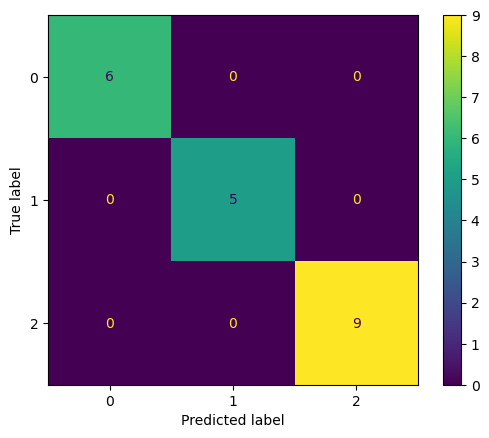

In [14]:
# plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [15]:
# display classification report
report = classification_report(y_true, y_pred, zero_division=0)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         9

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [16]:
# Save the trained_epoch, model, optimizer, and loss,
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, 'checkpoint.pth')

# Load the model, optimizer, and loss
checkpoint = torch.load('checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']